In [2]:
import numpy as np
from numpy import array, diag, arange, linspace, outer, trace, dot, pi, exp, sin, cos, sqrt
from numpy.random import uniform
from scipy.linalg import eig, eigh, norm, svd, kron, expm, sqrtm
from scipy.stats import gaussian_kde, unitary_group
from scipy.optimize import minimize

import qutip as qp
from qutip import rand_dm_hs

import time
import random
from functools import reduce

import mpmath as mp
mp.dps = 50
mp.pretty = True

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
X = np.array([[0.,1.],
              [1.,0.]]) # X Pauli matrix
Y = np.array([[0.,-1.j],
              [1.j, 0.]]) # Y Pauli matrix
Z = np.array([[1., 0.],
              [0.,-1.]]) # Z Pauli matrix
I = np.array([[1.,0.],
              [0.,1.]]) # 2x2 identity matrix

In [3]:
def fidelity(A, B):
    res = reduce(dot, [sqrtm(A), B, sqrtm(A)])
    res = sqrtm(res)
    return trace(res).real**2

def sup_fidelity(A, B):
    """ An upper bound for the usual fidelity """
    t1 = trace(A@B).real
    t2 = max(0, 1 - trace(A@A).real)
    t3 = max(0, 1 - trace(B@B).real)
    return t1 + sqrt(t2)*sqrt(t3)

In [4]:
def depolarizing_channel(density_matrix, p):        
    rho_x = reduce(dot, [X, density_matrix, X])
    rho_y = reduce(dot, [Y, density_matrix, Y])
    rho_z = reduce(dot, [Z, density_matrix, Z])
    return (1 - p)*density_matrix + p/3*(rho_x + rho_y + rho_z)


def local_depolarizing_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    Y_loc = [I] * n_qubits
    Y_loc[target_qubit] = Y
    Y_loc = reduce(kron, Y_loc)
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + (X_loc.dot(density_matrix).dot(X_loc) + Y_loc.dot(density_matrix).dot(Y_loc) + Z_loc.dot(density_matrix).dot(Z_loc)) * p / 3
        
    return new_density_matrix


def colored_noise_channel(n_qubits, density_matrix, t, alpha, target_qubit, gamma1=1e-4, gamma2=1e4):

    if alpha == 1:
        a = mp.log(mp.fdiv(gamma2, gamma1))
        c = mp.fdiv(1, a)
        def p(gamma):
            return mp.fmul(c, mp.fdiv(1, gamma))
    else:
        k = mp.fsub(alpha, 1)
        a = mp.fmul(gamma1, gamma2)
        a_power = mp.power(a, k)
        b = mp.fsub(mp.power(gamma2, k), mp.power(gamma1, k))
        c = mp.fdiv(a_power, b)
        def p(gamma):
            pp = mp.power(gamma, alpha)
            f = mp.fdiv(k, pp)
            return mp.fmul(f, c)
   
    def G(gamma):
        delta = mp.sqrt(gamma**2 - 4)
        delta_t = mp.fmul(delta, t)
        second = mp.fadd(mp.cosh(delta_t), mp.fdiv(mp.fmul(gamma, mp.sinh(delta_t)), delta))
        gamma_t = mp.fmul(gamma, t)
        return mp.fmul(mp.exp(-gamma_t), second)
        
    L = mp.quad(lambda gamma: mp.fmul(p(gamma), G(gamma)), [gamma1, gamma2])
    L = float(L.real)
    operator = [I] * n_qubits
    operator[target_qubit] = Z
    operator = reduce(kron, operator)
    term1 = (1 + L) / 2 * density_matrix
    term2 = (1 - L) / 2 * operator.dot(density_matrix).dot(operator)
    
    return np.array(term1 + term2, dtype=complex)

In [3]:
def train(dm_train, labels, x0=None, kernel_func=None, n_reps=1):
    
    fvals = []
    n_train = len(dm_train)

    if kernel_func is None:
        kernel_func = fidelity
    
    # compute the kernel matrix
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i + 1):
            K[i][j] = K[j][i] = kernel_func(dm_train[i], dm_train[j]).real**n_reps
    
    def fun(x):
        term1 = np.sum(x)
        lx = array(labels_train)*x
        term2 = 0
        for i in range(n_train):
            term2 += 0.5*lx[i]**2*K[i][i]
            for j in range(i):
                term2 += lx[i]*lx[j]*K[i][j]
        f = term1 - term2
        fvals.append(f)
        return -f
    
    # find optimal parameters
    bounds = [(0, None)]*n_train
    if x0 is None:
        x0 = uniform(0, 1e-6, n_train)
    constraints = {'type': 'eq',
                   'fun': lambda x: dot(x, labels)}
    optimization_result = minimize(fun=fun, x0=x0, method="SLSQP", bounds=bounds, constraints=constraints, options={"maxiter": 1e6})
    parameters = optimization_result.x
    
    return parameters, fvals, optimization_result, K

In [6]:
def find_bias(labels, parameters, K):
    index = parameters.argmax()   
    s = 0
    for i in range(n_train):
        s += labels[i]*parameters[i]*K[i][index]
    bias = labels[index] - s
    return bias

In [7]:
def classify(labels_train, parameters, bias, dm_train, dm_test, n_reps=1, kernel_func=None):

    if kernel_func is None:
        kernel_func = fidelity

    lp = array(labels_train)*array(parameters)
    predictions = []
    for i in range(len(dm_test)):
        s = 0
        for j in range(len(dm_train)):
            s += lp[j]*kernel_func(dm_train[j], dm_test[i]).real**n_reps
        m = s + bias
        predictions.append(m)

    assignments = np.sign(predictions)
    
    return assignments, predictions

In [8]:
def accuracy(labels, assignments):
    acc = 0
    for label, assignment in zip(labels, assignments):
        if label == assignment:
            acc += 1
    return acc/len(labels)

# Discrete 

In [9]:
alphas = [0.6, 0.8] # alphas to classify

n_train = 100 # train set size
n_test = 1000 # test set size

In [10]:
labels_train = [] # list for true labels for the training set
dm_train = [] # list of channeled density matrices for the training set
for i in range(n_train):
    label = random.sample([-1, 1], 1)[0] # generate a random class label
    labels_train.append(label) # store the label
    if label == -1:
        alpha = alphas[0] # pick the corresponding alpha
    elif label == 1:
        alpha = alphas[1] # pick the corresponding alpha
    dm = array(rand_dm_hs(2)) # generate a random density matrix
    # dm = array(qp.rand_ket(2)); dm = outer(dm, dm.conj().T) # generate a random density matrix
    # dm = np.array([[1/2]*2]*2)
    dm = depolarizing_channel(dm, alpha) # act with the depolarizing channel
    dm_train.append(dm) # store the channeled density matrix 
    
print('-1:', labels_train.count(-1))
print('+1:', labels_train.count(1))

-1: 65
+1: 35


In [11]:
labels_test = [] # list for true labels for the training set
dm_test = [] # list of channeled density matrices for the training set
for i in range(n_test):
    label = random.sample([-1, 1], 1)[0] # generate a random class label
    labels_test.append(label) # store the label
    if label == -1:
        alpha = alphas[0] # pick the corresponding alpha
    elif label == 1:
        alpha = alphas[1] # pick the corresponding alpha
    dm = array(rand_dm_hs(2)) # generate a random density matrix
    # dm = array(qp.rand_ket(2)); dm = outer(dm, dm.conj().T) # generate a random density matrix
    # dm = np.array([[1/2]*2]*2)
    dm = depolarizing_channel(dm, alpha) # act with the depolarizing channel
    dm_test.append(dm) # store the channeled density matrix 
    
print('-1:', labels_test.count(-1))
print('+1:', labels_test.count(1))

-1: 500
+1: 500


Completed in 61.20341610908508
Cost: -15922.594220148882
Optimization terminated successfully


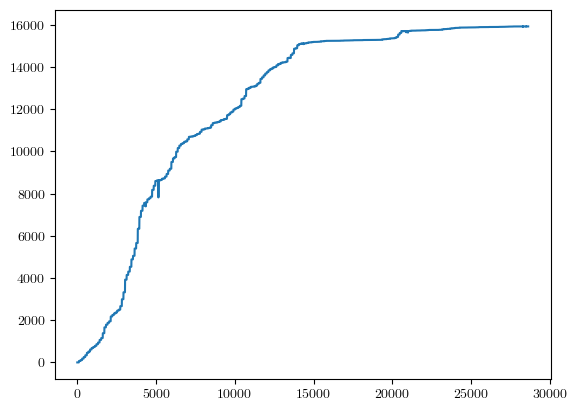

In [12]:
# kernel_func = lambda A, B: trace(A@B).real
# kernel_func = sup_fidelity
kernel_func = fidelity
n_reps = 1

start_time = time.time()
parameters, f_values, optimization_result, K = train(dm_train, labels_train, n_reps=n_reps, kernel_func=kernel_func)
bias = find_bias(labels_train, parameters, K)
print('Completed in', time.time() - start_time)
print("Cost:", optimization_result.fun)
print(optimization_result.message)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

1.0


/tmp/ipykernel_38313/2257010825.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


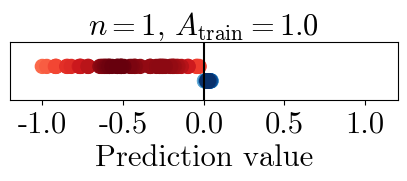

In [15]:
assignments_train, predictions_train = classify(labels_train, parameters, bias, dm_train, dm_train, n_reps=n_reps, kernel_func=kernel_func)
acc_train = accuracy(labels_train, assignments_train)
normer = np.max(np.abs(predictions_train))
print(acc_train)

predictions_train_p = []
predictions_train_m = []
for label, prediction in zip(labels_train, predictions_train):
    if label == 1:
        predictions_train_p.append(prediction)
    elif label == -1:
        predictions_train_m.append(prediction)
        
transp = 1
fontsize = 22
plt.figure(figsize=(5, 0.75))

cmap_p = plt.get_cmap('Blues')
colors_p = cmap_p(np.linspace(0.5, 1, cmap_p.N))
cmap_p = LinearSegmentedColormap.from_list('Blues', colors_p)
x = array(predictions_train_p)
y = array([0]*len(predictions_train_p))
c = gaussian_kde(predictions_train_p)(predictions_train_p)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_p, s=100, alpha=transp)

cmap_m = plt.get_cmap("Reds")
colors_m = cmap_m(np.linspace(0.5, 1, cmap_m.N))
cmap_m = LinearSegmentedColormap.from_list("Reds", colors_m)
x = array(predictions_train_m)
y = array([0.075]*len(predictions_train_m))
c = gaussian_kde(predictions_train_m)(predictions_train_m)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_m, s=100, alpha=transp)

plt.axvline(x=0, color="black")
plt.xlabel('Prediction value', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks([],[])
plt.xlim(np.min(predictions_train)*1.2, abs(np.max(predictions_train))*1.2)
plt.xlim(-1.2, 1.2)
plt.ylim(-0.1, 0.2)
# plt.title("$n="+ str(n_reps) +"$, accuracy: " + str(np.round(acc_test, 3)), fontsize=fontsize)
plt.title("$n="+ str(n_reps) +"$, $A_{\mathrm{train}}=" + str(np.round(acc_train, 3)) + "$", fontsize=fontsize)
plt.tight_layout()
plt.show()

/tmp/ipykernel_38313/1669224200.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


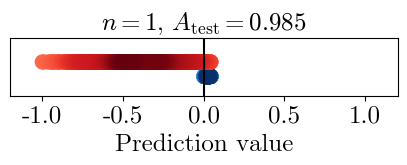

In [16]:
assignments_test, predictions_test = classify(labels_train, parameters, bias, dm_train, dm_test, n_reps=n_reps, kernel_func=kernel_func)
acc_test = accuracy(labels_test, assignments_test)
normer = np.max(np.abs(predictions_test))
    
predictions_test_p = []
predictions_test_m = []
for label, prediction in zip(labels_test, predictions_test):
    if label == 1:
        predictions_test_p.append(prediction)
    elif label == -1:
        predictions_test_m.append(prediction)
        
transp = 1
fontsize = 18
plt.figure(figsize=(5, 0.75))

cmap_p = plt.get_cmap('Blues')
colors_p = cmap_p(np.linspace(0.5, 1, cmap_p.N))
cmap_p = LinearSegmentedColormap.from_list('Blues', colors_p)
x = array(predictions_test_p)
y = array([0]*len(predictions_test_p))
c = gaussian_kde(predictions_test_p)(predictions_test_p)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_p, s=100, alpha=transp)

cmap_m = plt.get_cmap("Reds")
colors_m = cmap_m(np.linspace(0.5, 1, cmap_m.N))
cmap_m = LinearSegmentedColormap.from_list("Reds", colors_m)
x = array(predictions_test_m)
y = array([0.075]*len(predictions_test_m))
c = gaussian_kde(predictions_test_m)(predictions_test_m)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_m, s=100, alpha=transp)

plt.axvline(x=0, color="black")
plt.xlabel('Prediction value', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks([],[])
# plt.xlim(np.min(predictions_test)*1.2, np.max(predictions_test)*1.2)
plt.xlim(-1.2, 1.2)
plt.ylim(-0.1, 0.2)
plt.title("$n="+ str(n_reps) +"$, $A_{\mathrm{test}}=" + str(np.round(acc_test, 3)) + "$", fontsize=fontsize)
plt.tight_layout()
plt.savefig("Atest-Ntrain=" + str(n_train) + "-Ntest=" + str(n_test) + "-Nreps=" + str(n_reps) + "-alpha0=" + str(alphas[0]) + "-alpha1=" + str(alphas[1]) + ".pdf" , bbox_inches='tight', transparent=True)
plt.show()

In [17]:
No!

SyntaxError: invalid syntax (2148945196.py, line 1)

# Intervals

In [ ]:
n_train = 300


# regions_0 = [(0.0, 0.5)]
# regions_1 = [(0.5, 1.0)]

# regions_0 = [(0.1, 0.2)]
# regions_1 = [(0.7, 0.9)]

# regions_0 = [(0.0, 0.75)]
# regions_1 = [(0.25, 1.0)]

regions_0 = [(0.0, 0.25), (0.5, 0.75)]
regions_1 = [(0.25, 0.5), (0.75, 1.0)]

class_labels = [-1, 1]
n_classes = len(class_labels)

alphas_train = []
labels_train = []
for i in range(n_train):

    label = random.sample([-1, 1], 1)[0]
    if label == -1: 
        coin = random.sample([i for i in range(len(regions_0))], 1)[0]
        alpha = random.uniform(regions_0[coin][0], regions_0[coin][1])
    if label == 1:
        coin = random.sample([i for i in range(len(regions_1))], 1)[0]
        alpha = random.uniform(regions_1[coin][0], regions_1[coin][1])
        
    labels_train.append(label)
    alphas_train.append(alpha)

print(labels_train.count(-1), labels_train.count(1))

dm_train = []
# density_matrix = np.array([[1/2]*2]*2)
density_matrix = diag([1, 0])
# density_matrix = np.asarray(qp.rand_dm_hs(2))
for alpha in alphas_train:
    # density_matrix = np.array([[1/2]*2]*2)
    # density_matrix = np.asarray(qp.rand_dm_hs(2))
    dm = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_train.append(dm)

In [ ]:
n_test = 1000

alphas_test = []
labels_test = []
for i in range(n_test):
    label = random.sample([-1, 1], 1)[0]
    if label == -1: 
        coin = random.sample([i for i in range(len(regions_0))], 1)[0]
        alpha = random.uniform(regions_0[coin][0], regions_0[coin][1])
    if label == 1:
        coin = random.sample([i for i in range(len(regions_1))], 1)[0]
        alpha = random.uniform(regions_1[coin][0], regions_1[coin][1])
    labels_test.append(label)
    alphas_test.append(alpha)
        
dm_test = []
for alpha in alphas_test:
    # density_matrix = np.array([[1/2]*2]*2)
    # density_matrix = np.asarray(qp.rand_dm_hs(2))
    dm = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_test.append(dm)  

In [ ]:
n_reps = 2

start_time = time.time()
parameters, f_values, optimization_result, K = train(dm_train, labels_train, n_reps=n_reps)
bias = find_bias(labels_train, parameters, K)
print('Completed in', time.time() - start_time)
print(optimization_result.message)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

#### Train accuracy

In [ ]:
assignments_train, predictions_train = classify(labels_train, parameters, bias, dm_train, dm_train, n_reps)
acc_train = accuracy(labels_train, assignments_train)
normer = np.max(np.abs(predictions_train))
    
predictions_train_p = []
predictions_train_m = []
for label, prediction in zip(labels_train, predictions_train):
    if label == 1:
        predictions_train_p.append(prediction)
    elif label == -1:
        predictions_train_m.append(prediction)
        
transp = 1
fontsize = 22
plt.figure(figsize=(5, 0.75))

cmap_p = plt.get_cmap('Blues')
colors_p = cmap_p(np.linspace(0.0, 1, cmap_p.N))
cmap_p = LinearSegmentedColormap.from_list('Blues', colors_p)
x = array(predictions_train_p)
y = array([0]*len(predictions_train_p))
c = gaussian_kde(predictions_train_p)(predictions_train_p)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_p, s=100, alpha=transp)

cmap_m = plt.get_cmap("Reds")
colors_m = cmap_m(np.linspace(0.0, 1, cmap_m.N))
cmap_m = LinearSegmentedColormap.from_list("Reds", colors_m)
x = array(predictions_train_m)
y = array([0.075]*len(predictions_train_m))
c = gaussian_kde(predictions_train_m)(predictions_train_m)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_m, s=100, alpha=transp)

plt.axvline(x=0, color="black")
plt.xlabel('Prediction value', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks([],[])
plt.xlim(np.min(predictions_train)*1.2, abs(np.max(predictions_train))*1.2)
plt.xlim(-1.2, 1.2)
plt.ylim(-0.1, 0.2)
# plt.title("$n="+ str(n_reps) +"$, accuracy: " + str(np.round(acc_test, 3)), fontsize=fontsize)
plt.title("$n="+ str(n_reps) +"$, $A_{\mathrm{train}}=" + str(np.round(acc_train, 3)) + "$", fontsize=fontsize)
plt.tight_layout()
plt.show()

#### Test accuracy

In [ ]:
assignments_test, predictions_test = classify(labels_train, parameters, bias, dm_train, dm_test, n_reps)
acc_test = accuracy(labels_test, assignments_test)
normer = np.max(np.abs(predictions_test))
    
predictions_test_p = []
predictions_test_m = []
for label, prediction in zip(labels_test, predictions_test):
    if label == 1:
        predictions_test_p.append(prediction)
    elif label == -1:
        predictions_test_m.append(prediction)
        
transp = 1
fontsize = 18
plt.figure(figsize=(5, 0.75))

cmap_p = plt.get_cmap('Blues')
colors_p = cmap_p(np.linspace(0.0, 1, cmap_p.N))
cmap_p = LinearSegmentedColormap.from_list('Blues', colors_p)
x = array(predictions_test_p)
y = array([0]*len(predictions_test_p))
c = gaussian_kde(predictions_test_p)(predictions_test_p)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_p, s=100, alpha=transp)

cmap_m = plt.get_cmap("Reds")
colors_m = cmap_m(np.linspace(0.0, 1, cmap_m.N))
cmap_m = LinearSegmentedColormap.from_list("Reds", colors_m)
x = array(predictions_test_m)
y = array([0.075]*len(predictions_test_m))
c = gaussian_kde(predictions_test_m)(predictions_test_m)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x/normer, y, c=c, cmap=cmap_m, s=100, alpha=transp)

plt.axvline(x=0, color="black")
plt.xlabel('Prediction value', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks([],[])
# plt.xlim(np.min(predictions_test)*1.2, np.max(predictions_test)*1.2)
plt.xlim(-1.2, 1.2)
plt.ylim(-0.1, 0.2)
plt.title("$n="+ str(n_reps) +"$, $A_{\mathrm{test}}=" + str(np.round(acc_test, 3)) + "$", fontsize=fontsize)
plt.tight_layout()
# plt.savefig("Atest-Ntrain=" + str(n_train) + "-Ntest=" + str(n_test) + "-Nreps=" + str(n_reps) + "-I1-random_states.pdf" , bbox_inches='tight', transparent=True)
plt.show()